This notebook is the dispropotional stratified sampling variation of original notebook: https://www.kaggle.com/code/madhavmalhotra/creating-a-smaller-dataset-for-ciciot2023

The reason for this new notebook is that the dataset is highly-biased, with DoS/DDoS comprises the majority of datset while other attack types such as upload attack is very scares. 

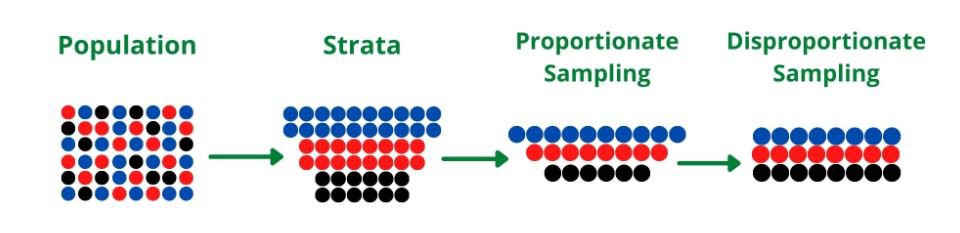
image from https://www.geeksforgeeks.org/stratified-sampling-in-pandas/ 

please refer to
* https://ubiai.tools/sampling-bias-in-machine-learning-fresh-update/ for basic concept about sampling bias.
* https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas for handling the case that certain label count is less than its dispropotional rate.

Note: output files are available with 34 original cyberattack labels (suffix `_34`), 8 simplified cyberattack types (suffix `_8`), or just cyberattack or no cyberattack (suffix `_2`).

&nbsp; &nbsp; &nbsp;

## Loading Libraries and Data

We created dataset copies with 34, 8, and 2 output labels. This is in case you want to classify cyberattacks in full detail vs. simplified detail vs. just cyberattack or no cyberattack. 

In [1]:
import os              # loading files
import numpy as np     # intermediary data handling
import pandas as pd    # data processing

In [2]:
# List CSV files
DATASET_DIRECTORY = "/kaggle/input/unb-cic-iot-dataset/wataiData/csv/CICIoT2023/"
csv_files = [k for k in os.listdir(DATASET_DIRECTORY) if k.endswith('.csv')]
csv_files.sort()
# csv_files[:5]

&nbsp; &nbsp; &nbsp;

## Dataset Extraction Functions

There's a function to sample random rows from the overall dataset, to remap IANA codes from integers to human-friendly labels, and to reduce memory usage by avoiding all float data types. 

In [3]:
import pandas as pd

# Create two Series
s1 = pd.Series({'A': 1, 'B': 2, 'C': 3})
s2 = pd.Series({'A': 4, 'B': 5, 'C': 6})

# Column names of s1
column_names = ['A', 'B', 'C']  # These represent the index of s1

# Initialize s0 with these column names as the index and all values set to 0
s0 = pd.Series(0, index=column_names)

# Add the Series
s0 += s1
s0 += s2
# print(s0)

column_names = pd.read_csv(DATASET_DIRECTORY+ csv_files[0], nrows=0).columns
from collections import Counter

ori_prop = Counter({})
dist_prop = Counter({})

In [4]:
import math

def sample_rows(df, percent_rows):
    '''
    Chooses some percentage of the dataframe's rows at random.
    Note that class balance is preserved. 
    
    Parameters
    ----------------------
    df (type: pd.DataFrame)
    percent_rows (type: float, range: 0-1)
    
    Returns
    ----------------------
    pd.DataFrame
    - Contains percent_rows of each class in input df
    '''
    
    labels = df['label'].unique()
    dfs_condensed = []
    
    total_num = df['label'].count()
    # print("total_num",total_num)
    proportions = df['label'].value_counts(normalize=True).sort_index()
    
    # Power transformation for controlled distortion
    power = 0.2  # Adjustable parameter: 0 < power <= 1
    transformed_proportions = proportions ** power

    # Normalize to ensure sum = 1
    distorted_proportions = transformed_proportions / transformed_proportions.sum()

    # Convert to a dictionary
#     distorted_map = dict(zip(proportions.index, distorted_proportions))
    distorted_map = distorted_proportions.to_dict()
    # Display proportions
    global ori_prop
    ori_prop += proportions.to_dict()
    global dist_prop
    dist_prop += distorted_proportions.to_dict()
    # print("Original proportions:", proportions.to_dict())
    # print("Distorted proportions (map):", distorted_map)
    
    # Select rows with chosen label
    for label in labels:
        mask = df['label'] == label
        df_by_label = df[mask]
        
        # Change Randomly sample some percentage of rows in current class
#         sample = df_by_label.sample(frac = percent_rows)
#         print(distorted_map.get(label))
        num_by_portion = math.floor(percent_rows * total_num * distorted_map.get(label))
        
        sample = df_by_label.sample(min(len(df_by_label),num_by_portion ))
        dfs_condensed.append(sample)
    
    # Shuffle all samples
    return pd.concat(dfs_condensed, ignore_index = True).sample(frac = 1)

In [5]:
# Map IANA Protocol numbers to strings (leave user option to 1-hot or numerically encode)
iana_map = { 
    "0": "HOPOPT", "1": "ICMP", "2": "IGMP", "3": "GGP", "4": "IPv4", "5": "ST", 
    "6": "TCP", "7": "CBT", "8": "EGP", "9": "IGP", "10": "BBN-RCC-MON", "11": "NVP-II", 
    "12": "PUP", "13": "ARGUS (deprecated)", "14": "EMCON", "15": "XNET", "16": "CHAOS", 
    "17": "UDP", "18": "MUX", "19": "DCN-MEAS", "20": "HMP", "21": "PRM", "22": "XNS-IDP", 
    "23": "TRUNK-1", "24": "TRUNK-2", "25": "LEAF-1", "26": "LEAF-2", "27": "RDP", 
    "28": "IRTP", "29": "ISO-TP4", "30": "NETBLT", "31": "MFE-NSP", "32": "MERIT-INP", 
    "33": "DCCP", "34": "3PC", "35": "IDPR", "36": "XTP", "37": "DDP", "38": "IDPR-CMTP", 
    "39": "TP++", "40": "IL", "41": "IPv6", "42": "SDRP", "43": "IPv6-Route", 
    "44": "IPv6-Frag", "45": "IDRP", "46": "RSVP", "47": "GRE", "48": "DSR", "49": "BNA", 
    "50": "ESP", "51": "AH", "52": "I-NLSP", "53": "SWIPE (deprecated)", "54": "NARP", 
    "55": "MOBILE", "56": "TLSP", "57": "SKIP", "58": "IPv6-ICMP", "59": "IPv6-NoNxt", 
    "60": "IPv6-Opts", "62": "CFTP", "64": "SAT-EXPAK", "65": "KRYPTOLAN", "66": "RVD", 
    "67": "IPPC", "69": "SAT-MON", "70": "VISA", "71": "IPCV", "72": "CPNX", "73": "CPHB", 
    "74": "WSN", "75": "PVP", "76": "BR-SAT-MON", "77": "SUN-ND", "78": "WB-MON", 
    "79": "WB-EXPAK", "80": "ISO-IP", "81": "VMTP", "82": "SECURE-VMTP", "83": "VINES", 
    "84": "IPTM", "85": "NSFNET-IGP", "86": "DGP", "87": "TCF", "88": "EIGRP", 
    "89": "OSPFIGP", "90": "Sprite-RPC", "91": "LARP", "92": "MTP", "93": "AX.25", 
    "94": "IPIP", "95": "MICP (deprecated)","96": "SCC-SP", "97": "ETHERIP", "98": "ENCAP", 
    "100": "GMTP", "101": "IFMP", "102": "PNNI", "103": "PIM", "104": "ARIS", "105": "SCPS", 
    "106": "QNX", "107": "A/N", "108": "IPComp", "109": "SNP", "110": "Compaq-Peer", 
    "111": "IPX-in-IP", "112": "VRRP", "113": "PGM", "114": "", "115": "L2TP", "116": "DDX",  
    "117": "IATP", "118": "STP", "119": "SRP", "120": "UTI", "121": "SMP", 
    "122": "SM (deprecated)", "123": "PTP","124": "ISIS over IPv4", "125": "FIRE", 
    "126": "CRTP", "127": "CRUDP", "128": "SSCOPMCE", "129": "IPLT", "130": "SPS", 
    "131": "PIPE", "132": "SCTP",  "133": "FC", "134": "RSVP-E2E-IGNORE", 
    "135": "Mobility Header", "136": "UDPLite", "137": "MPLS-in-IP", "138": "manet", 
    "139": "HIP", "140": "Shim6", "141": "WESP", "142": "ROHC", "143": "Ethernet", 
    "144": "AGGFRAG", "145": "NSH"
}

def iana_convert(df):
    df["Protocol Type"] = df["Protocol Type"].apply(lambda num : iana_map[ str(int(num)) ])
    return df

In [6]:
# Convert to reduced space dtypes to save data
dtypes = {
        'flow_duration': np.float32,
        'Header_Length': np.uint32,
        'Protocol Type': str,
        'Duration': np.float32,
        'Rate': np.uint32,
        'Srate': np.uint32,
        'Drate': np.float32,
        'fin_flag_number': np.bool_,
        'syn_flag_number': np.bool_,
        'rst_flag_number': np.bool_,
        'psh_flag_number': np.bool_,
        'ack_flag_number': np.bool_,
        'ece_flag_number': np.bool_,
        'cwr_flag_number': np.bool_,
        'ack_count': np.float16,
        'syn_count': np.float16,
        'fin_count': np.uint16,
        'urg_count': np.uint16, 
        'rst_count': np.uint16, 
        'HTTP': np.bool_, 
        'HTTPS': np.bool_, 
        'DNS': np.bool_, 
        'Telnet': np.bool_,
        'SMTP': np.bool_, 
        'SSH': np.bool_, 
        'IRC': np.bool_, 
        'TCP': np.bool_, 
        'UDP': np.bool_, 
        'DHCP': np.bool_, 
        'ARP': np.bool_, 
        'ICMP': np.bool_, 
        'IPv': np.bool_, 
        'LLC': np.bool_,
        'Tot sum': np.float32, 
        'Min': np.float32, 
        'Max': np.float32, 
        'AVG': np.float32, 
        'Std': np.float32, 
        'Tot size': np.float32, 
        'IAT': np.float32, 
        'Number': np.float32,
        'Magnitue': np.float32, 
        'Radius': np.float32, 
        'Covariance': np.float32, 
        'Variance': np.float32, 
        'Weight': np.float32, 
        'label': str
    }

def convert_dtype(df):
    # Adjust data type
    for col,typ in dtypes.items():
        df[col] = df[col].astype(typ)   
    
    # Format column names to lowercase snake
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Fix spelling error in original dataset
    df['magnitude'] = df['magnitue']
    return df.drop(['magnitue'], axis=1)

In [7]:
# Create raw label maps, simplified label maps, and cyberattack/no cyberattack label maps
reduced_labels = {
    'DDoS-RSTFINFlood': 'DDoS', 'DDoS-PSHACK_Flood': 'DDoS', 'DDoS-SYN_Flood': 'DDoS', 
    'DDoS-UDP_Flood': 'DDoS', 'DDoS-TCP_Flood': 'DDoS', 'DDoS-ICMP_Flood': 'DDoS', 
    'DDoS-SynonymousIP_Flood': 'DDoS', 'DDoS-ACK_Fragmentation': 'DDoS', 
    'DDoS-UDP_Fragmentation': 'DDoS', 'DDoS-ICMP_Fragmentation': 'DDoS', 
    'DDoS-SlowLoris': 'DDoS', 'DDoS-HTTP_Flood': 'DDoS', 'DoS-UDP_Flood': 'DoS', 
    'DoS-SYN_Flood': 'DoS', 'DoS-TCP_Flood': 'DoS', 'DoS-HTTP_Flood': 'DoS', 
    'Mirai-greeth_flood': 'Mirai', 'Mirai-greip_flood': 'Mirai', 'Mirai-udpplain': 'Mirai', 
    'Recon-PingSweep': 'Recon', 'Recon-OSScan': 'Recon', 'Recon-PortScan': 'Recon', 
    'VulnerabilityScan': 'Recon', 'Recon-HostDiscovery': 'Recon', 'DNS_Spoofing': 'Spoofing', 
    'MITM-ArpSpoofing': 'Spoofing', 'BenignTraffic': 'Benign', 'BrowserHijacking': 'Web', 
    'Backdoor_Malware': 'Web', 'XSS': 'Web', 'Uploading_Attack': 'Web', 'SqlInjection': 'Web', 
    'CommandInjection': 'Web', 'DictionaryBruteForce': 'BruteForce'
}


def label_map(df_34):
    df_8 = df_34.copy()
    df_2 = df_34.copy()
    
    # Adjust label classes
    df_8['label'] = df_8['label'].apply(lambda attack_name : reduced_labels[attack_name])
    df_2['benign'] = df_2['label'] == 'BenignTraffic'
    df_2 = df_2.drop(['label'], axis=1)
    
    return df_34,df_8,df_2

## Save CSV

In [8]:
def write_helper(dfs, filename, append=True):
    """ Creates or appends """
    
    df_34,df_8,df_2 = dfs
    
    if append:
        df_34.to_csv(filename+'_34classes.csv', mode='a', index=False, header=False)
        df_8.to_csv(filename+'_8classes.csv', mode='a', index=False, header=False)
        df_2.to_csv(filename+'_2classes.csv', mode='a', index=False, header=False)
    else:
        df_34.to_csv(filename+'_34classes.csv', index=False)
        df_8.to_csv(filename+'_8classes.csv', index=False)
        df_2.to_csv(filename+'_2classes.csv', index=False)

In [9]:
def combine_csv(csv_files, percent):
    '''
    For memory-efficiency, extracts rows from one original CSV at a time. 
    Then, combines the rows into a larger CSV.
    
    Parameters
    ---------------------
    csv_files (type: list)
    - Filepaths to the raw CSV files
    
    Returns
    ---------------------
    None
    - Outputs to CSV file instead
    '''
    
    # Init CSV
    dfs = label_map(convert_dtype(iana_convert(sample_rows( 
        pd.read_csv(DATASET_DIRECTORY + csv_files[0]), percent_rows=percent
    ))))
    write_helper(dfs, f'/kaggle/working/{percent}_dist_percent', append=False)
    del dfs
    
    print(f"Appending into {percent} csv")
    for csv in csv_files[1:]:
        print(".", end="")
        
        # Preprocessing
        dfs = label_map(convert_dtype(iana_convert(sample_rows( 
            pd.read_csv(DATASET_DIRECTORY + csv), percent_rows=percent
        ))))
        
        # Append to CSV
        write_helper(dfs, f'/kaggle/working/{percent}_dist_percent')
        del dfs

In [10]:
# for percent in [0.001, 0.005, 0.01, 0.05, 0.1]:
for percent in [0.001, 0.005]:
    combine_csv(csv_files[:2], percent=percent)

Appending into 0.001 csv
.Appending into 0.005 csv
.

## show intuitive view of dispropotional sampling
We use the pie chart to show the propotion of each label before and after the sampling

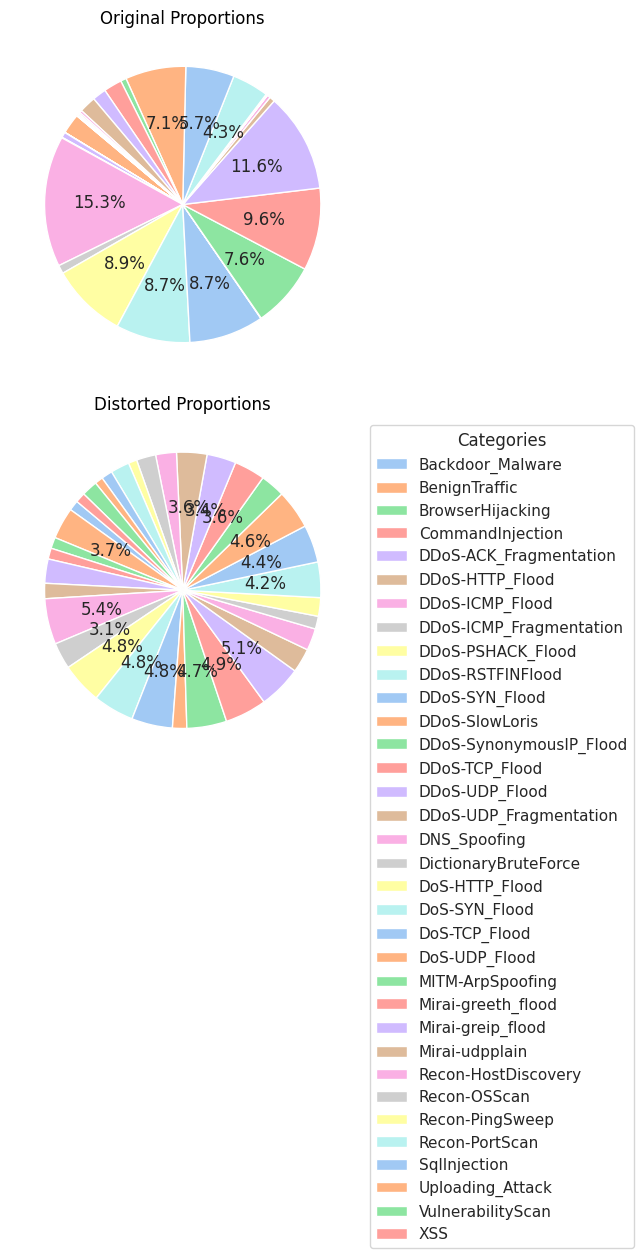

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract labels and values
ori_labels = list(ori_prop.keys())
ori_values = list(ori_prop.values())

dist_labels = list(dist_prop.keys())
dist_values = list(dist_prop.values())

threshold = 3  # Only show slices > 5%

# Define custom autopct function
def autopct_format(pct):
    return f'{pct:.1f}%' if pct > threshold else ''

# Set up the figure
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Seaborn theme for consistency
sns.set_theme(style="whitegrid")

# Plot original proportions
patches, _, _ = axes[0].pie(
    ori_values,
    # labels=ori_labels,
    autopct=autopct_format,
    startangle=140,
    colors=sns.color_palette("pastel")
)
axes[0].set_title("Original Proportions")

# Plot distorted proportions
axes[1].pie(
    dist_values,
    # labels=dist_labels,
    autopct=autopct_format,
    startangle=140,
    colors=sns.color_palette("pastel")
)
axes[1].set_title("Distorted Proportions")

# Add a legend outside the pie chart
plt.legend(patches, ori_labels, title="Categories", loc="upper left", bbox_to_anchor=(1.02, 1))
#supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

# Adjust layout
plt.tight_layout()
plt.show()
